In [1]:
#-- Install ultralytics for YOLO World --------------------------------------------------------------------------
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
#---------------------------------------------------------------------------------------------------------------

Ultralytics YOLOv8.2.61 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.7/8062.4 GB disk)


In [2]:
#-- Import -----------------------------------------------------------------------------------------------
from ultralytics import YOLO

import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.models import resnet50

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import os
import shutil
#---------------------------------------------------------------------------------------------------------------

In [3]:
#-- Initialize ---------------------------------------------------------------------------------------------------
out_path = '/kaggle/working/'
intput_path = '/kaggle/input/'

lbls_file = intput_path + 'all-labels/all_labels.txt'

drone_detector_weights_file = intput_path + 'drone-detection-yolov8-best-weights/best.pt'

# input_video_dir = intput_path + 'sample-videos-detecting-and-matching-objs-1/'
input_video_dir = intput_path + 'sample-movies-from-actors'
result_video_dir = out_path + 'result_videos/'

YOLO_Wordl_CONF_THRESHOLD = 0.25
YOLO_Wordl_IOU_THRESHOLD = 0.5

Drone_Detector_CONF_THRESHOLD = 0.25
Drone_Detector_IOU_THRESHOLD = 0.5

MOTION_THRESHOLD = 5
IOU_THRESHOLD = 0.5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:' , DEVICE)
#---------------------------------------------------------------------------------------------------------------

device: cpu


In [4]:
#-- Create Dir for saving Results ---------------------------------------------------------------------------------
os.makedirs(result_video_dir, exist_ok=True)
#-----------------------------------------------------------------------------------------------------------------

In [5]:
#-- Set labels for ZSOD Models ------------------------------------------------------------------------------------
# all_labels = ['drone', 'UAV', 'Unmanned Aerial Vehicle', 'Quadcopter']
all_labels = ['person']            

yolo_all_labels = all_labels
#-----------------------------------------------------------------------------------------------------------------

In [6]:
#-- Create and Initialize Obj Detection Models -------------------------------------------------------------------
#-- YOLO World --
model_yolo_world_zsod = YOLO('yolov8x-worldv2.pt')
model_yolo_world_zsod.set_classes(yolo_all_labels)


#-- Custome Model for Drone Detection --
model_drone_detector_yolov8 = YOLO(drone_detector_weights_file) 

display.clear_output()
print('All models loaded successfully :)')
#-----------------------------------------------------------------------------------------------------------------

All models loaded successfully :)


In [7]:
#-- calculate IOU for 2 Deteced Objects --------------------------------------------------------------------------
def calculate_iou(box1, box2):
    
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    x1_intersection = max(x1_1, x1_2)
    y1_intersection = max(y1_1, y1_2)
    x2_intersection = min(x2_1, x2_2)
    y2_intersection = min(y2_1, y2_2)
   
    intersection_area = max(0, x2_intersection - x1_intersection + 1) * max(0, y2_intersection - y1_intersection + 1)    
    box1_area = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    box2_area = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area

    return iou
#-----------------------------------------------------------------------------------------------------------------

In [8]:
#-- Load the pre-trained ResNet50 model for Feature Extraction from Images ---------------------------------------
model_resnet = resnet50(pretrained=True)
model_resnet = nn.Sequential(*list(model_resnet.children())[:-1])  # Remove the classification layer
model_resnet.eval()

display.clear_output()
print('ResNET model loaded successfully :)')
#-----------------------------------------------------------------------------------------------------------------


ResNET model loaded successfully :)


In [9]:
#-- Define a transform to preprocess the images ------------------------------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#-----------------------------------------------------------------------------------------------------------------

In [10]:
#-- Convert an OpenCV image to a PIL image -----------------------------------------------------------------------
def cv2_to_pil(image):    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return Image.fromarray(image)
#-----------------------------------------------------------------------------------------------------------------

In [11]:
#-- Extract features from an image using the pre-trained ResNet50 model ------------------------------------------
def extract_features(image):   
    image = cv2_to_pil(image)  # Convert from OpenCV to PIL
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model_resnet(image)
    features = features.squeeze().numpy()
    
    print(f'@@@@@ features size:{features.shape} @@@@@')
    
    return features
#-----------------------------------------------------------------------------------------------------------------

In [12]:
#-- Remove duplicate images based on similarity threshold ---------------------------------------------------------
def remove_duplicate_images(images, threshold):    
    features = [extract_features(image) for image in images]
    similarities = cosine_similarity(features, features)
    
    duplicates = set()
    similar_indexes = set()
    n = len(images)
    for i in range(n):
        for j in range(i+1, n):
            if similarities[i, j] >= threshold:
                duplicates.add(j)
                similar_indexes.add((i,j))
    
    unique_images = [images[i] for i in range(n) if i not in duplicates]
    
    return unique_images, similar_indexes
#-----------------------------------------------------------------------------------------------------------------

In [13]:
SHORT_TIME_PERIOD = 1
LONG_TIME_PERIOD = 4
SIM_THRESHOLD = 0.9

Processing Friends_2.mp4 ==========================================================
number_of_frames: 248
fps: 15
	Processing frame 1 ------------------------------

0: 384x640 6 persons, 1925.3ms
Speed: 10.6ms preprocess, 1925.3ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:6
	Processing frame 2 ------------------------------

0: 384x640 6 persons, 1843.0ms
Speed: 2.8ms preprocess, 1843.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:2
	Processing frame 3 ------------------------------

0: 384x640 6 persons, 1809.6ms
Speed: 4.0ms preprocess, 1809.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:0
	Processing frame 4 ------------------------------

0: 384x640 6 persons, 1783.0ms
Speed: 2.8ms preprocess, 1783.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 5 -----------------------------

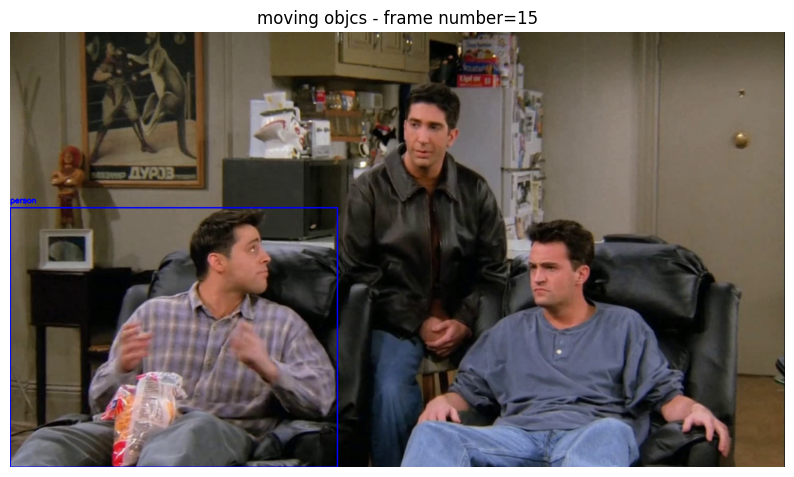

	Processing frame 16 ------------------------------

0: 384x640 6 persons, 1728.8ms
Speed: 2.7ms preprocess, 1728.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:1
	Processing frame 17 ------------------------------

0: 384x640 6 persons, 1719.3ms
Speed: 2.8ms preprocess, 1719.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:1
	Processing frame 18 ------------------------------

0: 384x640 6 persons, 1705.1ms
Speed: 3.3ms preprocess, 1705.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 19 ------------------------------

0: 384x640 6 persons, 1752.7ms
Speed: 3.6ms preprocess, 1752.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 20 ------------------------------

0: 384x640 6 persons, 1703.1ms
Speed: 2.9ms preprocess, 1703.1ms inference, 0.9ms postprocess per image at 

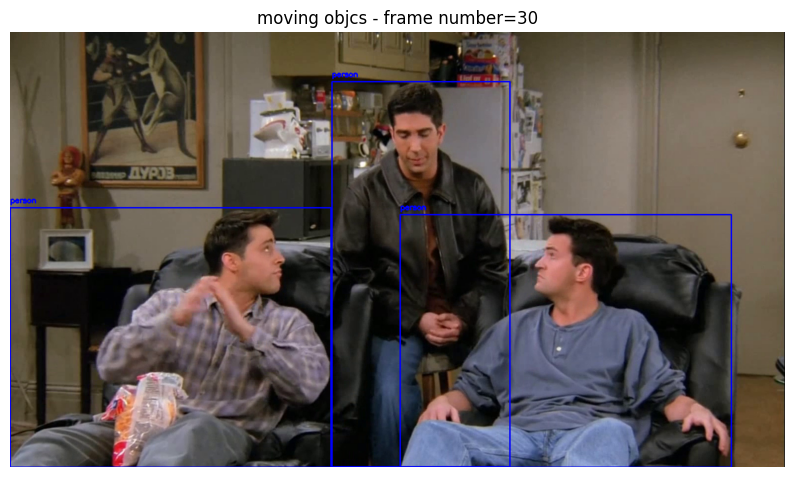

	Processing frame 31 ------------------------------

0: 384x640 6 persons, 1670.0ms
Speed: 2.6ms preprocess, 1670.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 32 ------------------------------

0: 384x640 6 persons, 1715.8ms
Speed: 2.9ms preprocess, 1715.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 33 ------------------------------

0: 384x640 6 persons, 1711.3ms
Speed: 2.8ms preprocess, 1711.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 34 ------------------------------

0: 384x640 6 persons, 1703.5ms
Speed: 2.7ms preprocess, 1703.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 35 ------------------------------

0: 384x640 6 persons, 1698.1ms
Speed: 2.7ms preprocess, 1698.1ms inference, 1.0ms postprocess per image at 

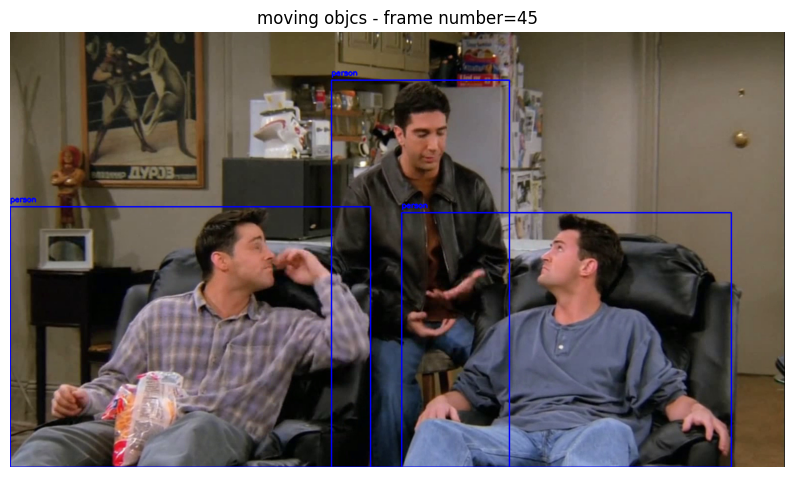

	Processing frame 46 ------------------------------

0: 384x640 6 persons, 1708.0ms
Speed: 2.6ms preprocess, 1708.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 47 ------------------------------

0: 384x640 6 persons, 1747.0ms
Speed: 2.7ms preprocess, 1747.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 48 ------------------------------

0: 384x640 6 persons, 1747.9ms
Speed: 2.4ms preprocess, 1747.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 49 ------------------------------

0: 384x640 6 persons, 1771.0ms
Speed: 2.8ms preprocess, 1771.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Number of Moving Objects:3
	Processing frame 50 ------------------------------

0: 384x640 5 persons, 1710.8ms
Speed: 3.6ms preprocess, 1710.8ms inference, 0.9ms postprocess per image at 

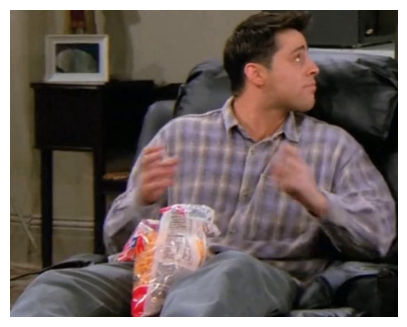

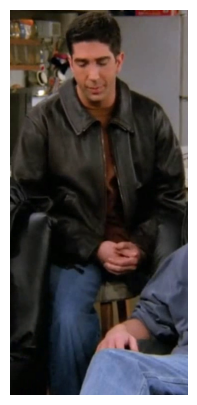

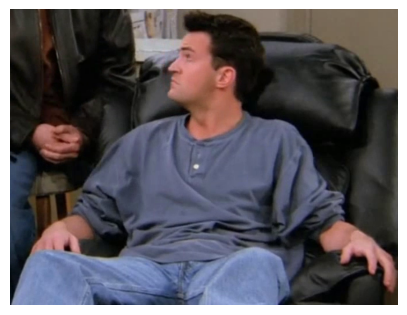

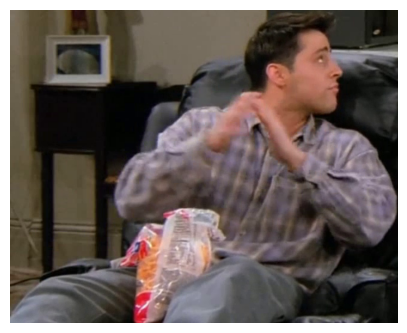

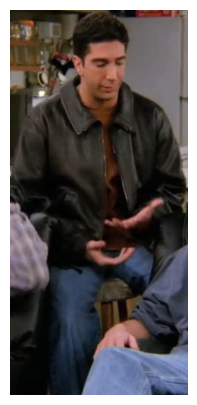

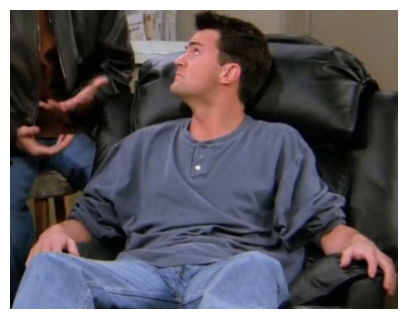

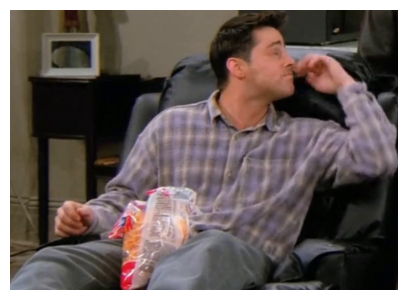

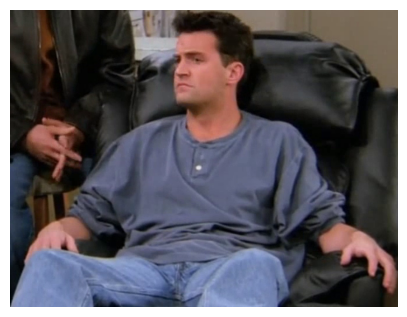

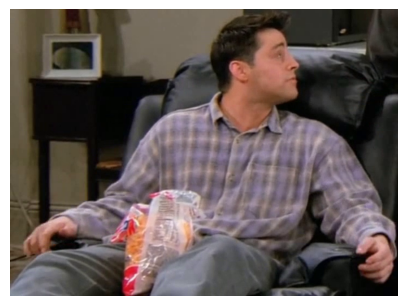

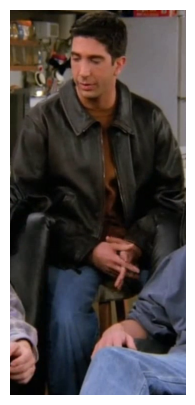

Duplicate Objects ===============================================
Unique Objects ===============================================


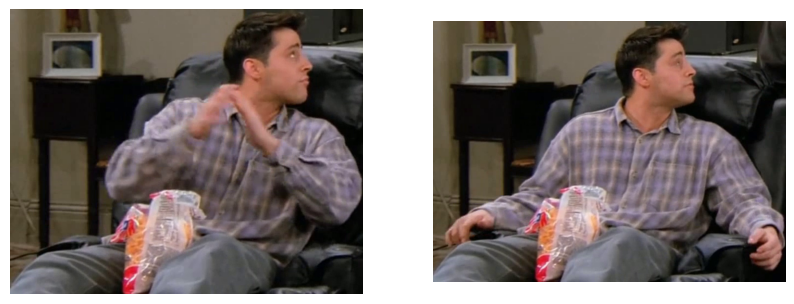

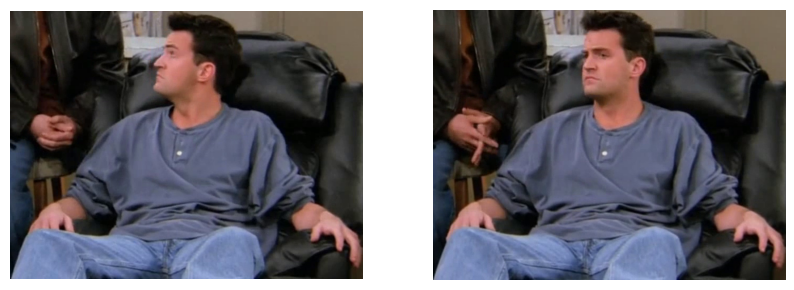

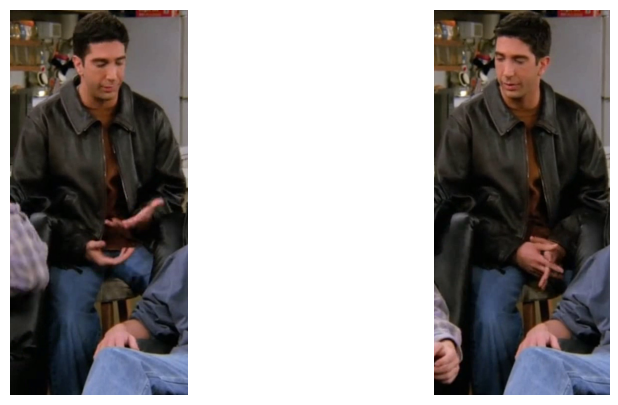

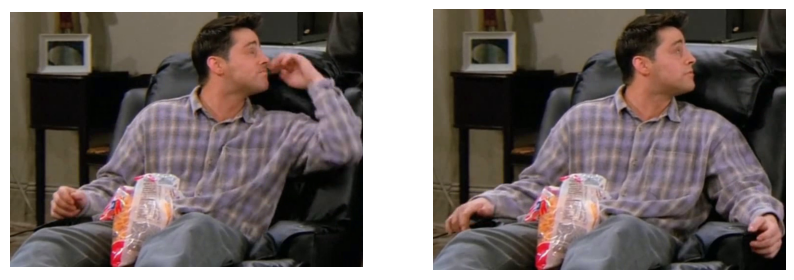

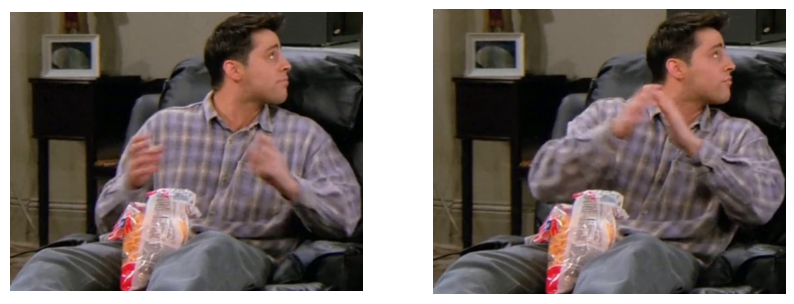

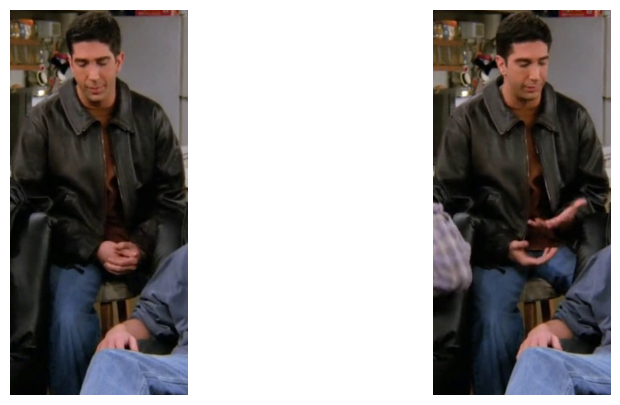

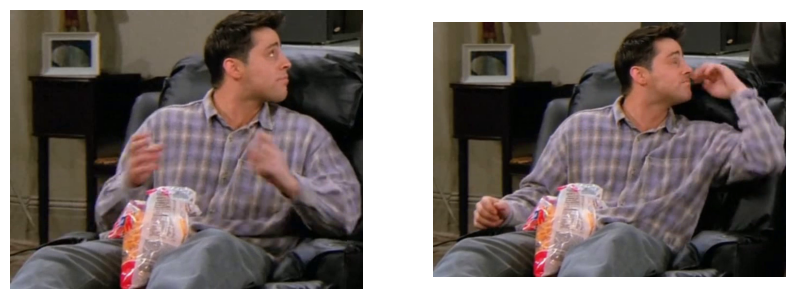

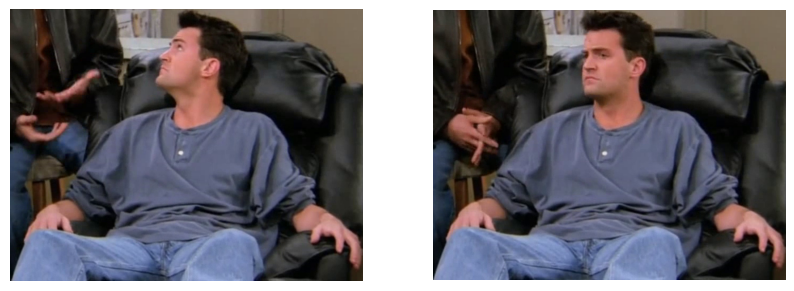

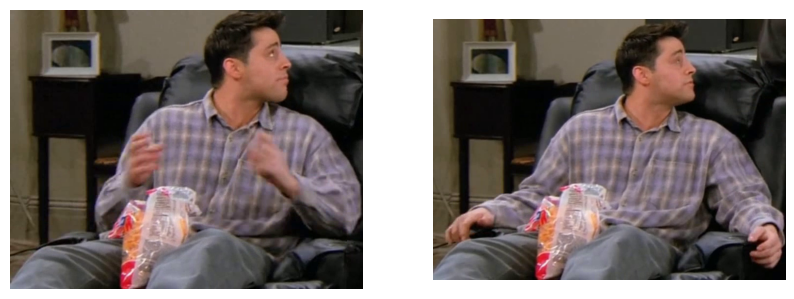

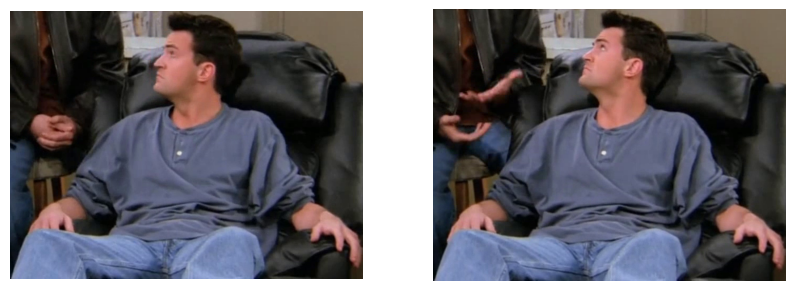

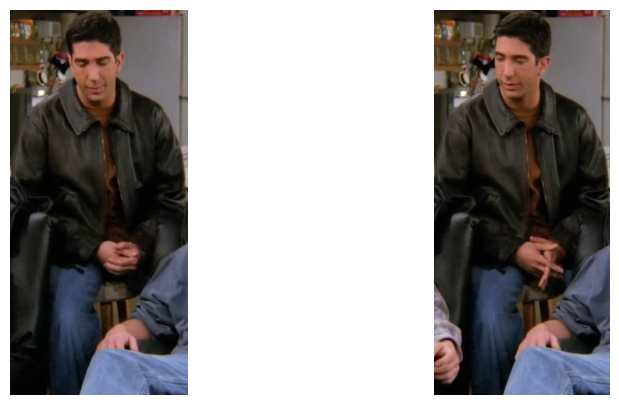

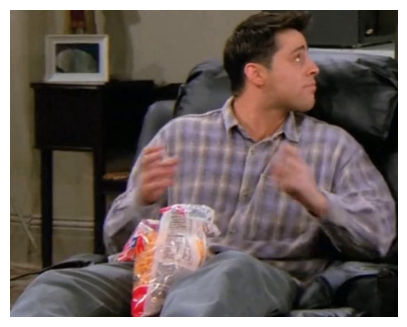

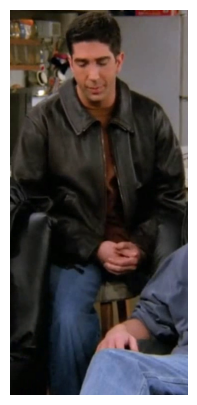

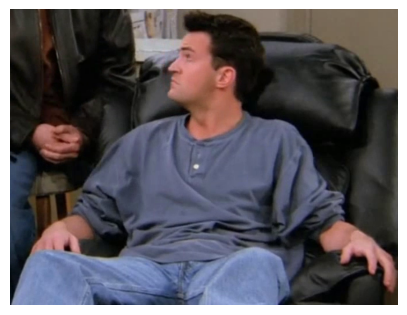

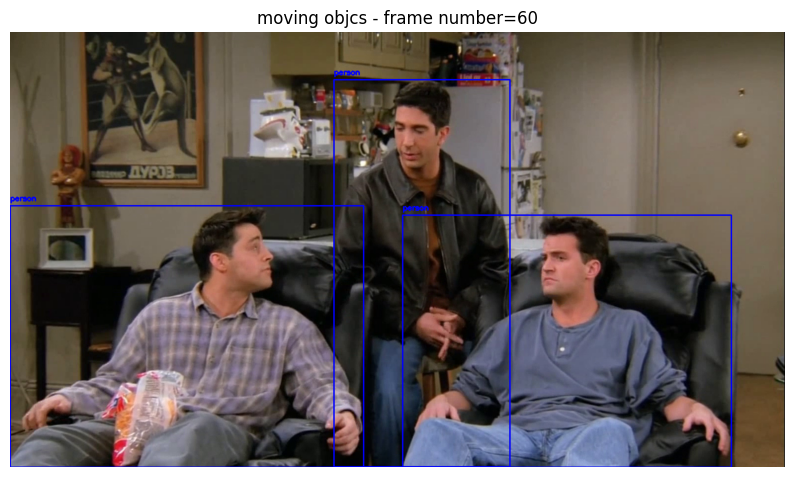

:)


In [14]:
#-- Run -----------------------------------------------------------------------------------------------------
for video_file in os.listdir(input_video_dir):      
    
    if video_file != 'Friends_2.mp4':
        continue
    
#     if 'human' not in video_file:
#         continue
    

    #-- log --
    print(f'Processing {video_file} ==========================================================')
    
    #-- background subtractor --
    # back_sub = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=25, detectShadows=False)
    back_sub = cv2.createBackgroundSubtractorMOG2(history=250, varThreshold=50, detectShadows=False)
    
    #-- Create Folder for saving results --
    dot_index = video_file.rfind('.')   
    video_result_dir_name = 'result_for_' + video_file[:dot_index]
    video_result_dir_path = result_video_dir + video_result_dir_name + '/'
    os.makedirs(video_result_dir_path, exist_ok=True)
        
    #-- load video --
    video_path = os.path.join(input_video_dir, video_file)    
    video = cv2.VideoCapture(video_path)
    
    #-- Get number of frames and fps -- 
    number_of_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    print(f'number_of_frames: {number_of_frames}\nfps: {fps}')

    #-- Get the width and height of the frames --
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    
    #-- Initialize VideoWriter to save the output video --
    result_video = cv2.VideoWriter(video_result_dir_path + video_file[:dot_index] + '.mp4',
                                   fourcc,
                                   fps,
                                   (frame_width, frame_height))   
    
    
    #-- Run Object Detection Models Frame by Frame --
    short_time_objs = dict()
    frame_number = 0
    
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        
        main_frame = frame.copy()
        frame_number += 1   
        #-- log --
        print(f'\tProcessing frame {frame_number} ------------------------------')       
        
        
        #-- Apply background subtraction --
        fg_mask = back_sub.apply(frame)        
        
#         #-- show some frames --
#         if frame_number%(LONG_TIME_PERIOD*fps) == 0:
#             plt.figure(figsize=(5, 5))
#             plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#             plt.axis('off')
#             plt.title(f'main frame - frame number={frame_number}')
#             file_name = f'main_frame_{frame_number}.png'
#             plt.savefig(video_result_dir_path + file_name)
#             plt.show()

#             plt.figure(figsize=(5, 5))
#             plt.imshow(cv2.cvtColor(fg_mask, cv2.COLOR_BGR2RGB))
#             plt.axis('off')
#             plt.title(f'fg_mask - frame number={frame_number}')
#             file_name = f'fg_mask_{frame_number}.png'
#             plt.savefig(video_result_dir_path + file_name)
#             plt.show()
        
#         #-- Detect Drone objects --
#         results = model_drone_detector_yolov8.predict(source=frame,
#                                                       conf=Drone_Detector_CONF_THRESHOLD,
#                                                       iou=Drone_Detector_IOU_THRESHOLD,
#                                                       show=False,
#                                                       save=False)
        
#         #-- Get only moving objects from results_yolov8_drone --
#         moving_objects = []        
#         for result in results:
#             for box in result.boxes:  
#                 class_id = int(box.cls) 
#                 label = yolo_all_labels[class_id]    
#                 bbox = box.xyxy.tolist()[0]            
#                 x1, y1, x2, y2 = map(int, bbox)                

#                 #-- Check if the detected object has motion --
#                 if fg_mask[y1:y2, x1:x2].mean() > MOTION_THRESHOLD:  
#                     moving_objects.append((x1, y1, x2, y2, label))     
        
        #-- Detect Person objects --
        results = model_yolo_world_zsod.predict(source=frame,
                                                conf=YOLO_Wordl_CONF_THRESHOLD,
                                                iou=YOLO_Wordl_IOU_THRESHOLD,
                                                show=False,
                                                save=False)
        
        
        #-- Get only moving objects from results_yolo_world_zsod --
        moving_objects = []        
        for result in results:
            for box in result.boxes:  
                class_id = int(box.cls)                 
                label = yolo_all_labels[class_id]    
                bbox = box.xyxy.tolist()[0]            
                x1, y1, x2, y2 = map(int, bbox)                

                #-- Check if the detected object has motion --
                if fg_mask[y1:y2, x1:x2].mean() > MOTION_THRESHOLD:  
                    moving_objects.append((x1, y1, x2, y2, label))  
        
        
        #-- log --
        print(f'Number of Moving Objects:{len(moving_objects)}')
        
        #-- crop objects and plot bounding box for moving objects on the frame --
        croped_objs = []
        for i, (x1, y1, x2, y2, label) in enumerate(moving_objects):            
            #-- crop detected object --
            cropped_object = main_frame[y1:y2, x1:x2]
            
            if frame_number%(SHORT_TIME_PERIOD*fps) == 0:
                croped_objs.append(cropped_object)
            
            #-- save coped object --
            if frame_number%(SHORT_TIME_PERIOD*fps) == 0:
                file_name = f'frame_{frame_number}_{i}_{label}.png'            
                cv2.imwrite(video_result_dir_path + file_name, cropped_object)
            
#             #-- show cropped object --
#             if frame_number%(SHORT_TIME_PERIOD*fps) == 0:
#                 plt.figure(figsize=(3, 3))
#                 plt.imshow(cropped_object)
#                 plt.axis('off')
#                 plt.title(label)
#                 plt.show
            
            #-- plot bbox on the frame --
            color = (255, 0, 0)               
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)  #-- Red box with thickness 2 --               
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        if frame_number%(SHORT_TIME_PERIOD*fps) == 0:
            short_time_objs[frame_number] = croped_objs
        
        if frame_number%(LONG_TIME_PERIOD*fps) == 0:           
            all_objs = [obj for sublist in short_time_objs.values() for obj in sublist]
            if len(all_objs)>1:
                unique_objs, similar_objs = remove_duplicate_images(all_objs, SIM_THRESHOLD)
            else:
                unique_objs = all_objs
                similar_objs = []
            
            #-- log --
            print('All Objects ===============================================')
            for img in all_objs:
                plt.figure(figsize=(5, 5))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')                
                plt.show()   
                
            print('Duplicate Objects ===============================================')
            for (i,j) in similar_objs:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(cv2.cvtColor(all_objs[i], cv2.COLOR_BGR2RGB))                
                axes[0].axis('off')  
                axes[1].imshow(cv2.cvtColor(all_objs[j], cv2.COLOR_BGR2RGB))                
                axes[1].axis('off')  
                plt.show
            
            print('Unique Objects ===============================================')
            for img in unique_objs:
                plt.figure(figsize=(5, 5))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')                
                plt.show()  

            
            
            
        #-- Add frame to result video --
        result_video.write(frame)

        #-- show some frames --
        if frame_number%(SHORT_TIME_PERIOD*fps) == 0:
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'moving objcs - frame number={frame_number}')
            file_name = f'moving_objcs_{frame_number}.png'
            plt.savefig(video_result_dir_path + file_name)
            plt.show()   
            
        if frame_number%(LONG_TIME_PERIOD*fps) == 0:   
            break
        
        
        
       
        
        
    #-- zip results --
    shutil.make_archive(out_path+video_result_dir_name, 'zip', video_result_dir_path)    

    #-- release videos --
    video.release()
    result_video.release()      
    
    


#-- remove folders --
# shutil.rmtree(result_video_dir)
# display.clear_output()   
print(':)')
#-----------------------------------------------------------------------------------------------------------------    
    